**Описание проекта**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;
personal.csv — персональные данные клиента;
internet.csv — информация об интернет-услугах;
phone.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
contract=pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
contract.columns=contract.columns.str.lower()

In [4]:
contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
pd.to_numeric(contract['totalcharges'], errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: totalcharges, Length: 7043, dtype: float64

In [7]:
personal=pd.read_csv('/datasets/final_provider/personal.csv')

In [8]:
personal.columns=personal.columns.str.lower()

In [9]:
personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerid       7043 non-null object
gender           7043 non-null object
seniorcitizen    7043 non-null int64
partner          7043 non-null object
dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
internet=pd.read_csv('/datasets/final_provider/internet.csv')

In [12]:
internet.columns=internet.columns.str.lower()

In [13]:
internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerid          5517 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [15]:
phone=pd.read_csv('/datasets/final_provider/internet.csv')

In [16]:
phone.columns=phone.columns.str.lower()

In [17]:
phone.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerid          5517 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
contract['churn'] = 1
contract.loc[contract['enddate'] == 'No', 'churn'] = 0
contract['churn'] = contract['churn'].astype('bool')
contract['enddate1']= contract['enddate'].replace('No', '2020-02-01')
contract['begindate']= pd.to_datetime(contract['begindate'], format='%Y-%m-%d')
contract['enddate']= pd.to_datetime(contract['enddate'], format='%Y-%m-%dT%H:%M:%S',errors='coerce')
contract.loc[contract['totalcharges'] == ' ', 'totalcharges'] = contract['monthlycharges']
contract['totalcharges'] = contract['totalcharges'].astype('float')
contract['begin_year'] = pd.DatetimeIndex(contract['begindate']).year
contract['end_year'] = pd.DatetimeIndex(contract['enddate1']).year
contract['begin_month'] = pd.DatetimeIndex(contract['begindate']).month
contract['end_month'] = pd.DatetimeIndex(contract['enddate1']).month
contract['months'] = ((contract['end_year']- contract['begin_year']) * 12 + (contract['end_month'] - contract['begin_month']))
contract = contract.drop(['begin_year','end_year','begin_month','end_month', 'enddate1'], axis=1)

- форматируем столбцы с датой
- для недавних клиентов столбец TotalCharges пустой, поэтому заполнили суммой за месяц.
- удалили столбцы
- добавлен признак month, показыающий длительность пользования услугами

In [20]:
data = contract.merge(personal, on='customerid', how='left')
data = data.merge(internet, on=['customerid'], how='left')
data = data.merge(phone, on=['customerid','internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies'], how='left')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerid          7043 non-null object
begindate           7043 non-null datetime64[ns]
enddate             1869 non-null datetime64[ns]
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
churn               7043 non-null bool
months              7043 non-null int64
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
dtypes: bool(1), d

In [22]:
data.head(3)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,months,...,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,False,1,...,0,Yes,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,False,34,...,0,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,2,...,0,No,No,DSL,Yes,Yes,No,No,No,No


In [23]:
for k in ['internetservice','onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']:
    data[k] = data[k].fillna('NA') # Not Applicable
data['enddate'] = data['enddate'].fillna('No')    
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerid          7043 non-null object
begindate           7043 non-null datetime64[ns]
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
churn               7043 non-null bool
months              7043 non-null int64
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
dtypes: bool(1), datetime6

- объединил данные в одну таблицу
- заполнил пропуски

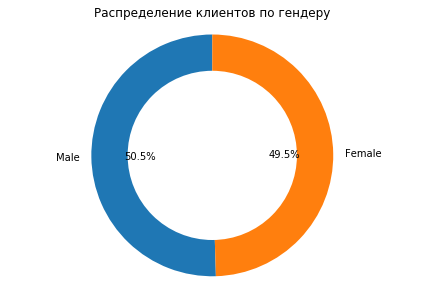

In [24]:
import matplotlib.pyplot as plt
labels = ['Male', 'Female']
sizes = data['gender'].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Распределение клиентов по гендеру")
plt.show()
plt.show()

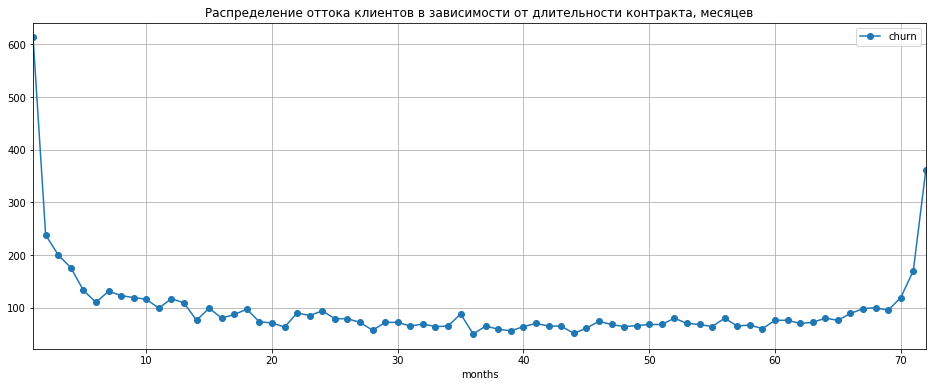

In [25]:
data.pivot_table(values = 'churn', index ='months', aggfunc='count').query('months > 0').plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Распределение оттока клиентов в зависимости от длительности контракта, месяцев")
plt.show()

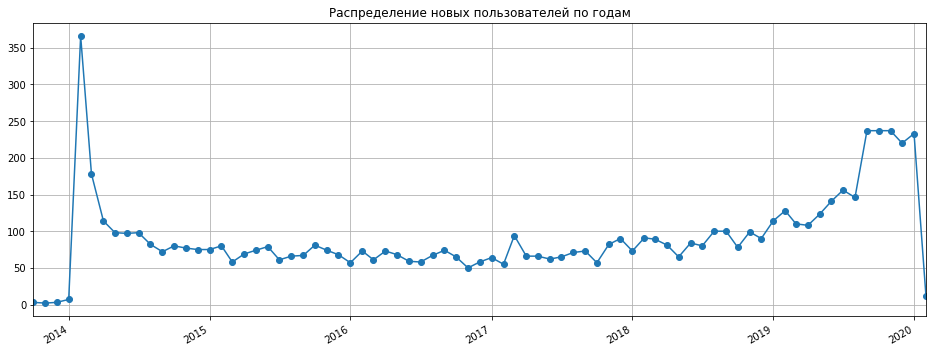

In [26]:
data['begindate'].value_counts().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Распределение новых пользователей по годам")
plt.show()

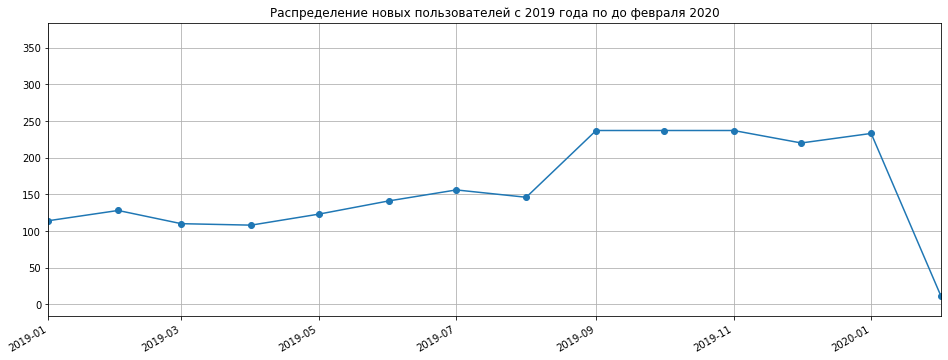

In [27]:
data['begindate'].value_counts().plot(style='o-',xlim = ('2019', '2020-02'), grid=True,figsize=(16, 6))
plt.title("Распределение новых пользователей с 2019 года по до февраля 2020")
plt.show()

- Распределение по гендерам практически одинаковое.
- Чаще всего от услуг компании отказываются новые клиенты - те, кто пользуются услугами меньше 10 месяцев.
- Наблдюдается с 2018 года прирост пользователей (возможно удачная реклама), и за период август- сентябрь 2019 подключилось сразу много новых клиентов. Однако с января по февраль 2020 пошло что-то не так.

In [28]:
df = data
df = df.drop(['begindate', 'enddate'], axis=1)

df_to_ohe = df.drop(['customerid', 'monthlycharges', 'totalcharges', 'churn', 'months'], axis=1)
df_no_ohe = df[['customerid', 'monthlycharges', 'totalcharges', 'churn', 'months']]
df_to_ohe = pd.get_dummies(df_to_ohe, drop_first=True)

df = df_no_ohe.join(df_to_ohe).drop(['customerid'], axis=1)

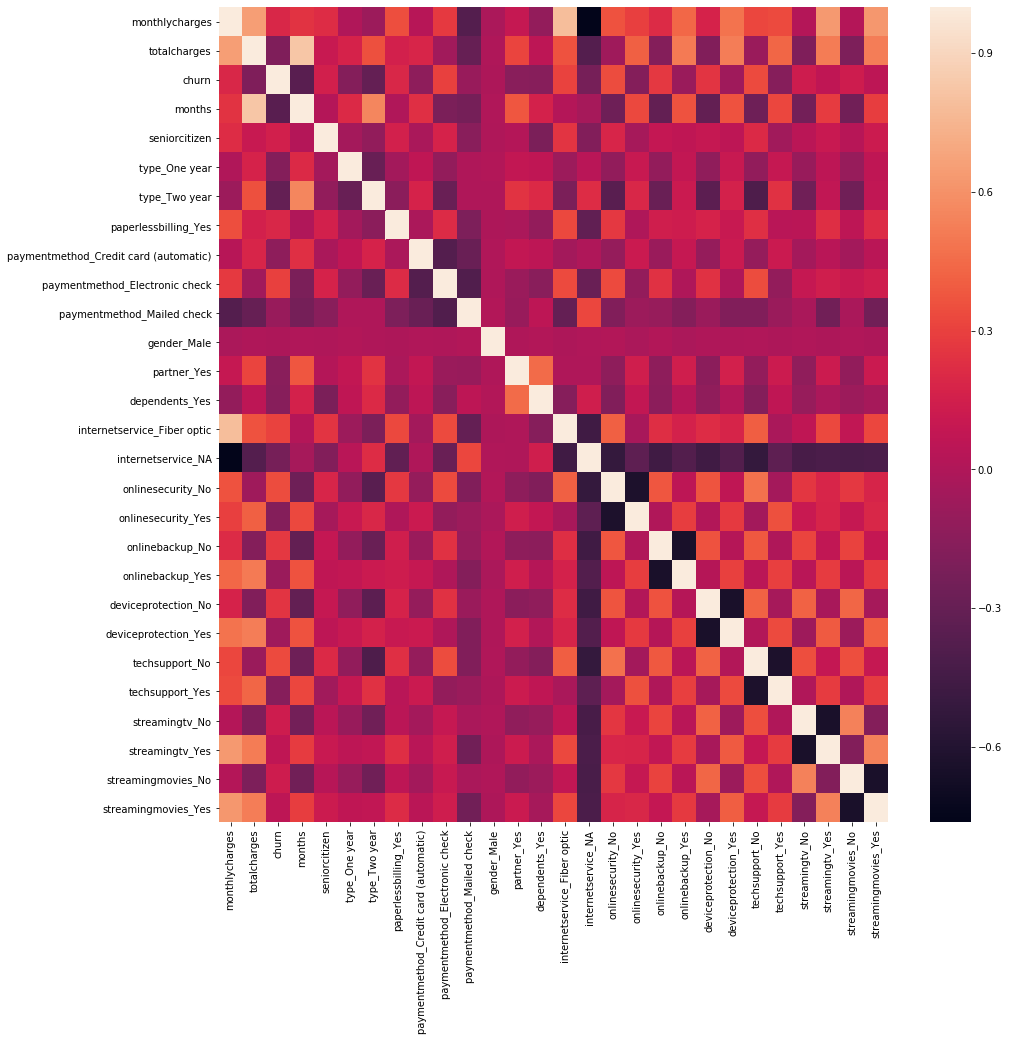

In [29]:
import seaborn as sns
corrMatrix = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrMatrix, annot=False)

проблематика мультиколлинеарности не обнаружена

In [30]:
target = df['churn']
features = df.drop('churn', axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=2576)
features_train, features_valid, target_train, target_valid = train_test_split(
   features_other, target_other, test_size=0.25, random_state=2576)

print('features_train', len(features_train))
print('features_valid', len(features_valid))
print('features_test', len(features_test))

features_train 4225
features_valid 1409
features_test 1409


- кодируем данные
- разбиваем датасет
- перейдем к обучению моделей

In [31]:
pd.set_option('display.max_columns', 150)
features_train

,monthlycharges,totalcharges,months,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,partner_Yes,dependents_Yes,internetservice_Fiber optic,internetservice_NA,onlinesecurity_No,onlinesecurity_Yes,onlinebackup_No,onlinebackup_Yes,deviceprotection_No,deviceprotection_Yes,techsupport_No,techsupport_Yes,streamingtv_No,streamingtv_Yes,streamingmovies_No,streamingmovies_Yes
6755,79.90,3313.40,42,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
6134,44.70,276.50,6,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
1254,88.80,4805.30,55,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0
1727,71.05,2168.15,31,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0
2408,20.85,892.15,45,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389,69.15,3649.60,51,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4689,19.90,57.40,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5757,25.70,734.60,28,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3152,95.85,2475.35,26,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0,1


In [32]:
total_result = pd.DataFrame(columns = ['model', 'roc_auc_valid', 'recall_valid', 'precision_valid'])

**Логистическая регрессия**

In [33]:
model_log = LogisticRegression(random_state=12345, class_weight='balanced')
model_log.fit(features_train, target_train)
predictions_log_train = model_log.predict(features_train)
predictions_log_valid = model_log.predict(features_valid)
roc_auc_log_train = roc_auc_score(target_train, predictions_log_train)
roc_auc_log_valid = roc_auc_score(target_valid, predictions_log_valid)
recall_log_valid = recall_score(target_valid, predictions_log_valid)
precision_log_valid = precision_score(target_valid, predictions_log_valid)
print('Качество логистической регрессии на обучающей выборке:', roc_auc_log_train )
print('Качество логистической регрессии на валидационной выборке:', roc_auc_log_valid )

total_result.loc[2,'model'] = 'LogisticRegression'
total_result.loc[2,'roc_auc_valid'] = roc_auc_log_valid
total_result.loc[2,'recall_valid'] = recall_log_valid
total_result.loc[2,'precision_valid'] = precision_log_valid

Качество логистической регрессии на обучающей выборке: 0.7647625070140598
Качество логистической регрессии на валидационной выборке: 0.7476554787759131


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**LightGBM**

In [34]:
cat_features = [c for c, col in enumerate(features_train.columns) if col not in (df_no_ohe.columns)]

In [35]:
model_lgb = lgb.LGBMClassifier(learning_rate=0.5, max_depth=1, n_estimators=60, min_child_samples = 10, class_weight='balanced',
                               reg_alpha = 0,objective='binary', metric = 'auc', random_state=2576)
model_lgb.fit(features_train, target_train, categorical_feature=cat_features)

probabilities_valid = model_lgb.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

lgb_score = roc_auc_score(target_valid, probabilities_one_valid)
recall_lgb_valid = recall_score(target_valid, probabilities_one_valid.round())
precision_lgb_valid = precision_score(target_valid, probabilities_one_valid.round())

total_result.loc[4,'model'] = 'LGBMClassifier'
total_result.loc[4,'roc_auc_valid'] = lgb_score
total_result.loc[4,'recall_valid'] = recall_lgb_valid
total_result.loc[4,'precision_valid'] = precision_lgb_valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [36]:
total_result

,model,roc_auc_valid,recall_valid,precision_valid
2,LogisticRegression,0.747655,0.75,0.535135
4,LGBMClassifier,0.849443,0.805556,0.54811


**CatBoost**

In [37]:
model_cb_1 = CatBoostClassifier(depth = 10, learning_rate = 0.1, l2_leaf_reg = 1, eval_metric='AUC', random_state=2576)
model_cb_1.fit(features_train, target_train, verbose=100, plot=True)

probabilities_valid = model_cb_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


total_result.loc[5,'model'] = 'CatBoostClassifier_1'
total_result.loc[5,'roc_auc_valid'] = roc_auc_score(target_valid, probabilities_one_valid)
total_result.loc[5,'recall_valid'] = recall_score(target_valid, probabilities_one_valid.round())
total_result.loc[5,'precision_valid'] = precision_score(target_valid, probabilities_one_valid.round())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 70.8ms	remaining: 1m 10s
100:	total: 7.43s	remaining: 1m 6s
200:	total: 15s	remaining: 59.8s
300:	total: 22.9s	remaining: 53.2s
400:	total: 30s	remaining: 44.8s
500:	total: 37.4s	remaining: 37.3s
600:	total: 44.4s	remaining: 29.5s
700:	total: 51.3s	remaining: 21.9s
800:	total: 58.3s	remaining: 14.5s
900:	total: 1m 5s	remaining: 7.17s
999:	total: 1m 12s	remaining: 0us


In [38]:
model_cb_2 = CatBoostClassifier(eval_metric='AUC')
model_cb_2.fit(features_train, target_train, verbose=100, plot=True)

probabilities_valid = model_cb_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

total_result.loc[6,'model'] = 'CatBoostClassifier_2'
total_result.loc[6,'roc_auc_valid'] = roc_auc_score(target_valid, probabilities_one_valid)
total_result.loc[6,'recall_valid'] = recall_score(target_valid, probabilities_one_valid.round())
total_result.loc[6,'precision_valid'] = precision_score(target_valid, probabilities_one_valid.round())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.02519
0:	total: 3.94ms	remaining: 3.94s
100:	total: 2.09s	remaining: 18.6s
200:	total: 4.15s	remaining: 16.5s
300:	total: 6.14s	remaining: 14.3s
400:	total: 8.33s	remaining: 12.4s
500:	total: 10.4s	remaining: 10.4s
600:	total: 12.3s	remaining: 8.19s
700:	total: 14.5s	remaining: 6.18s
800:	total: 17.2s	remaining: 4.27s
900:	total: 19.9s	remaining: 2.19s
999:	total: 22.5s	remaining: 0us


In [39]:
total_result.sort_values(by = 'roc_auc_valid', ascending = False)

,model,roc_auc_valid,recall_valid,precision_valid
4,LGBMClassifier,0.849443,0.805556,0.54811
6,CatBoostClassifier_2,0.832572,0.497475,0.670068
5,CatBoostClassifier_1,0.807598,0.469697,0.632653
2,LogisticRegression,0.747655,0.75,0.535135


Модели обучены и лучшие показатели видны у LGBMClassifier, данная модель лучше всего найдет положительные ответы, т.е. тех клиентов, которые уйдут.
Значение recall у LGBMClassifier самое высокое, а вот точность вышла средняя, лучше справилась модель CatBoostClassifier_2.
Далее посчитаем метрику на тестовой выборке и выясним какая модель лучше.Также посмотрим на accuracy и матрицы ошибок.

In [40]:
test_result = pd.DataFrame(columns = ['model', 'roc_auc_test', 'accuracy_test'])

model_lgb.fit(features_train, target_train, categorical_feature=cat_features)
probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

test_result.loc[0,'model'] = 'LGBMClassifier'
test_result.loc[0,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)
test_result.loc[0,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())

confusion_matrix(target_test, probabilities_one_test.round())

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


array([[765, 258],
       [ 59, 327]])

In [41]:
probabilities_test = model_cb_1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

test_result.loc[1,'model'] = 'CatBoostClassifier_1'
test_result.loc[1,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)
test_result.loc[1,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())

confusion_matrix(target_test, probabilities_one_test.round())

array([[922, 101],
       [203, 183]])

In [42]:
probabilities_test = model_cb_2.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

test_result.loc[2,'model'] = 'CatBoostClassifier_2'
test_result.loc[2,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)
test_result.loc[2,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())

confusion_matrix(target_test, probabilities_one_test.round())

array([[930,  93],
       [189, 197]])

In [43]:
test_result.sort_values(by = 'roc_auc_test', ascending = False)

,model,roc_auc_test,accuracy_test
0,LGBMClassifier,0.879353,0.775018
2,CatBoostClassifier_2,0.866236,0.799858
1,CatBoostClassifier_1,0.832441,0.784244


In [44]:
test_result.head(1)

,model,roc_auc_test,accuracy_test
0,LGBMClassifier,0.879353,0.775018


**Вывод**

Матрица ошибок у LGBMClassifier показывает, что данная модель лидирует и говорит нам о том, что она с большей вероятностью по сравнению с остальными моделями найдет тех клиентов, которые собираются уйти. 
Этот вывод также подтверждается тем, что у модели самое маленькое количество ложноотрицательных ответов - модель реже других присваивает клиенту ложный статус Churn = 0.
Accuracy у LGBMClassifier не самое высокое по сравнению с другими моделями, но в целом значения у всех близки друг к другу и не являются плохими.

In [45]:
print(model_lgb.feature_importances_)

[14  9 13  2  3  2  2  0  1  1  1  0  1  1  0  1  4  1  0  0  0  1  0  0
  2  0  1]


In [46]:
importances = list(model_lgb.feature_importances_)


Text(0.5, 1.0, 'Variable Importances')

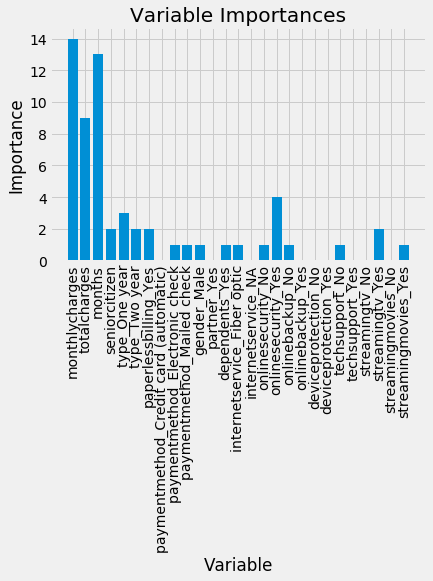

In [47]:
feature_list = list(features.columns)
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

При помощи feature_importances_ посмотроил столбцевую диаграмму исходя из которой видим, что 3 основных фактора это monthlycharges, totalcharges,month ну и немного выделяется на фоне остальных наличие интернет безопасности.
Соответственно можно сильно сузить внимание на нескольких факторах, что будет определенно плюсом для дальнейших исследований и прогнозов оттока клиентов.